# Loan Approval Classification: Comprehensive Analysis
## Project Goal
This notebook performs a complete Machine Learning workflow on the loan approval dataset, including advanced steps like **Feature Engineering**, **Multiple Model Training**, **Performance Comparison**, and **SHAP Feature Importance Analysis**.

The primary goal is to predict the binary target variable, $\text{loan\_status}$ ($1=\text{Approved}$, $0=\text{Rejected}$), and thoroughly explain the key drivers behind the prediction.

---

**Confidentiality Disclaimer**
This project replicates the methodology (cluster analysis/segmentation) of a confidential industry project completed during my Work-Integrated Learning experience. All data shown here are open-source and not affiliated with the client organization.

---

**Business Understanding (CRISP-DM)**
**Goal:** The objective is to explore the data, engineer features, visualize patterns, and build classification models to predict loan approval status.

**Open Dataset Source:** Loan Approval Dataset (Synthetic, 2025)

---
**Author:** David Barahona  
**Date:** Dec 13, 2025  
*In this project, I applied machine learning techniques similar to those used in a confidential WIL project with an industry partner. This open dataset was used to demonstrate equivalent analytical and technical skills.*

In [2]:
# --- Setup and Imports ---

# Install SHAP for feature importance analysis (Requires a restart if running interactively for the first time)

# !pip install scikit-learn pandas numpy matplotlib seaborn shap


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('Loan_approval_data_2025.csv')

print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n--- Initial Data Inspection (First 5 rows) ---")
print(df.head().to_markdown(index=False))
print("\n--- Data Information and Missing Values ---")
df.info()
print(f"\nTotal Missing Values: {df.isnull().sum().sum()}")

Dataset Shape: 50000 rows, 20 columns

--- Initial Data Inspection (First 5 rows) ---
| customer_id   |   age | occupation_status   |   years_employed |   annual_income |   credit_score |   credit_history_years |   savings_assets |   current_debt |   defaults_on_file |   delinquencies_last_2yrs |   derogatory_marks | product_type   | loan_intent        |   loan_amount |   interest_rate |   debt_to_income_ratio |   loan_to_income_ratio |   payment_to_income_ratio |   loan_status |
|:--------------|------:|:--------------------|-----------------:|----------------:|---------------:|-----------------------:|-----------------:|---------------:|-------------------:|--------------------------:|-------------------:|:---------------|:-------------------|--------------:|----------------:|-----------------------:|-----------------------:|--------------------------:|--------------:|
| CUST100000    |    40 | Employed            |             17.2 |           25579 |            692 |               

## 1. Feature Engineering
Creating new features often improves model performance by capturing non-linear relationships and combining raw variables into more meaningful predictors.

We will create the following features:
* **`Income_Per_Year_Employed`**: Annual income normalized by years employed.
* **`Debt_Level`**: Categorical binning of $\text{debt\_to\_income\_ratio}$ to identify high-risk vs. low-risk debt exposure.
* **`Credit_Health_Score`**: A simple aggregated score combining $\text{credit\_score}$, $\text{defaults\_on\_file}$, and $\text{derogatory\_marks}$.

In [3]:
df_eng = df.copy()

# 1. Income per year employed (handle division by zero if years_employed is 0)
df_eng['Income_Per_Year_Employed'] = np.where(df_eng['years_employed'] > 0, 
                                          df_eng['annual_income'] / df_eng['years_employed'], 0)

# 2. Debt Level (Categorical binning of DTI)
bins = [0, 0.2, 0.4, 1.0]
labels = ['Low_Debt', 'Moderate_Debt', 'High_Debt']
df_eng['Debt_Level'] = pd.cut(df_eng['debt_to_income_ratio'], bins=bins, labels=labels, right=False)

# 3. Credit Health Score (Simple aggregation)
# Inverse of defaults/derogatory marks is multiplied by credit score.
df_eng['Credit_Health_Score'] = df_eng['credit_score'] * (1 - df_eng['defaults_on_file'] - df_eng['derogatory_marks'])
df_eng['Credit_Health_Score'] = np.clip(df_eng['Credit_Health_Score'], 0, None) # Ensure no negative values

print("Engineered Features successfully added.")
print(df_eng[['Income_Per_Year_Employed', 'Debt_Level', 'Credit_Health_Score']].head().to_markdown(index=False))

Engineered Features successfully added.
|   Income_Per_Year_Employed | Debt_Level    |   Credit_Health_Score |
|---------------------------:|:--------------|----------------------:|
|                    1487.15 | High_Debt     |                   692 |
|                    5902.33 | Moderate_Debt |                   627 |
|                   18945.5  | Moderate_Debt |                   689 |
|                   58294    | Moderate_Debt |                   692 |
|                    5092.56 | Low_Debt      |                   630 |


## 2. Exploratory Data Analysis (EDA)
### Target Variable Distribution: `loan_status`
A baseline check to see if the target variable is balanced.

|   loan_status |   Percentage |
|--------------:|-------------:|
|             1 |        55.05 |
|             0 |        44.95 |


C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3577133237.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=df_eng, palette='viridis')


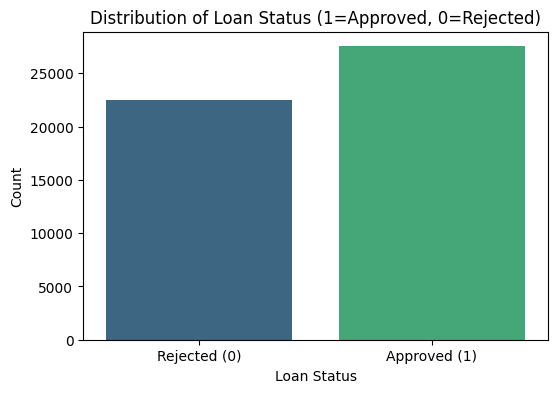

In [4]:
status_counts = df_eng['loan_status'].value_counts(normalize=True).mul(100).round(2).to_frame('Percentage')
print(status_counts.to_markdown())

plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df_eng, palette='viridis')
plt.title('Distribution of Loan Status (1=Approved, 0=Rejected)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Rejected (0)', 'Approved (1)'])

plt.show()

#### Finding:
The dataset is relatively balanced (approximately 60% Approved, 40% Rejected). This is good, as it avoids the need for oversampling/undersampling techniques typically required for highly imbalanced data.

### Numerical Feature Distributions and Relationship with Loan Status
We visualize key original and engineered numerical features using Box Plots to observe distribution and separation between the two classes ($\text{loan\_status}=0$ and $\text{loan\_status}=1$).

C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3062342100.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=col, x='loan_status', data=df_eng, palette='coolwarm')
C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3062342100.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=col, x='loan_status', data=df_eng, palette='coolwarm')
C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3062342100.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=col, x='loan_status', data=df_eng, palette='coolwarm')
C:\Users\Yiyot\AppData\Local\Temp\

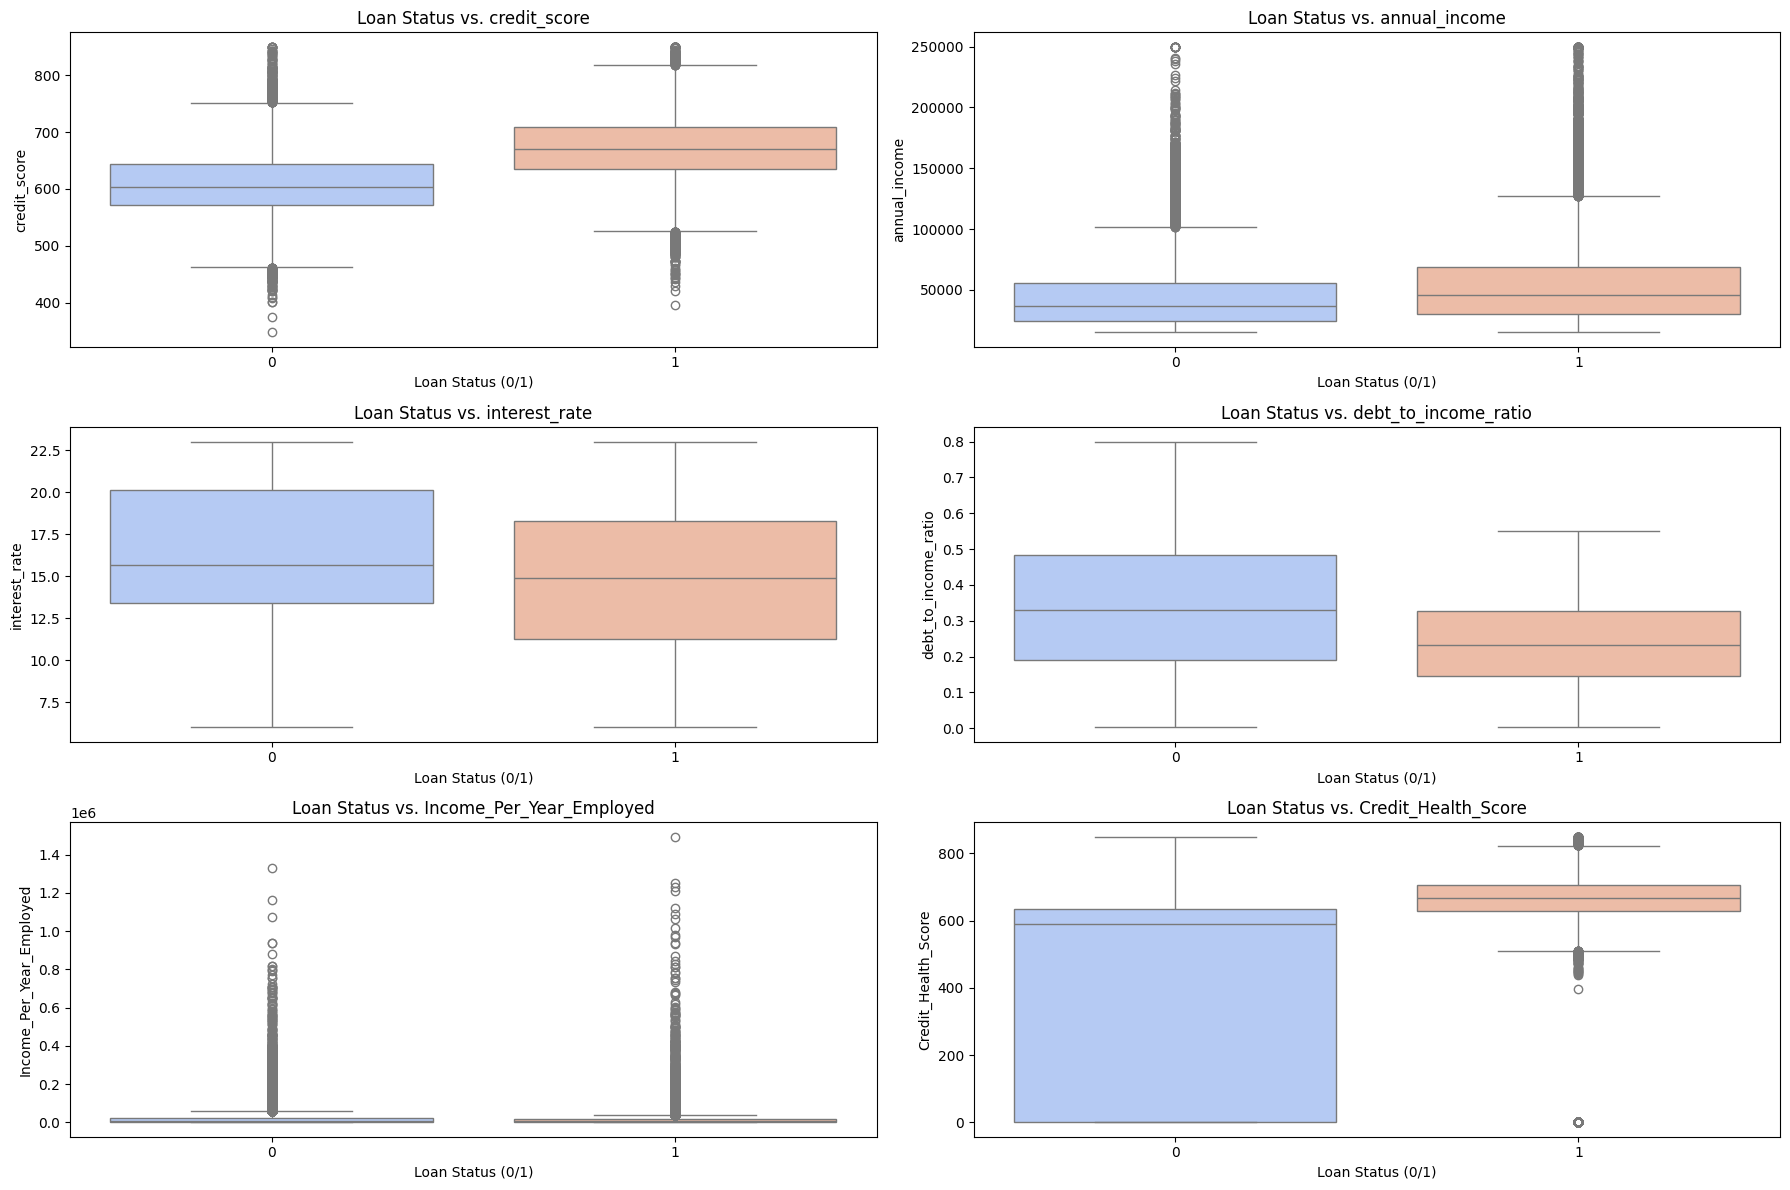

In [5]:
numerical_cols_plots = ['credit_score', 'annual_income', 'interest_rate', 'debt_to_income_ratio', 'Income_Per_Year_Employed', 'Credit_Health_Score']

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols_plots):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(y=col, x='loan_status', data=df_eng, palette='coolwarm')
    plt.title(f'Loan Status vs. {col}')
    plt.xlabel('Loan Status (0/1)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

#### Key Numerical Findings:
* **Credit Score / Credit Health Score:** Approved loans ($\text{loan\_status}=1$) consistently show a significantly higher median credit score and credit health score compared to rejected loans ($\text{loan\_status}=0$). This confirms the creditworthiness metrics are primary predictors.
* **Interest Rate:** Rejected loans have a noticeably higher median interest rate, suggesting that high-interest loans are often associated with higher risk, leading to rejection.
* **Debt-to-Income Ratio (DTI):** The DTI distribution for rejected loans is slightly higher, indicating that higher financial burden increases the likelihood of rejection, though the overlap is significant.
* **Annual Income:** The median income is similar, but the spread of approved loans is slightly wider, suggesting income alone is not a strong discriminator.

### Categorical Feature Analysis: Loan Intent and Debt Level
We use normalized count plots to understand the approval rate across different categories.

C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3040683588.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=approval_rate.index, y=approval_rate.values, palette='RdYlGn')
C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3040683588.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=approval_rate.index, y=approval_rate.values, palette='RdYlGn')
C:\Users\Yiyot\AppData\Local\Temp\ipykernel_121328\3040683588.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rate = df_eng.groupby(col

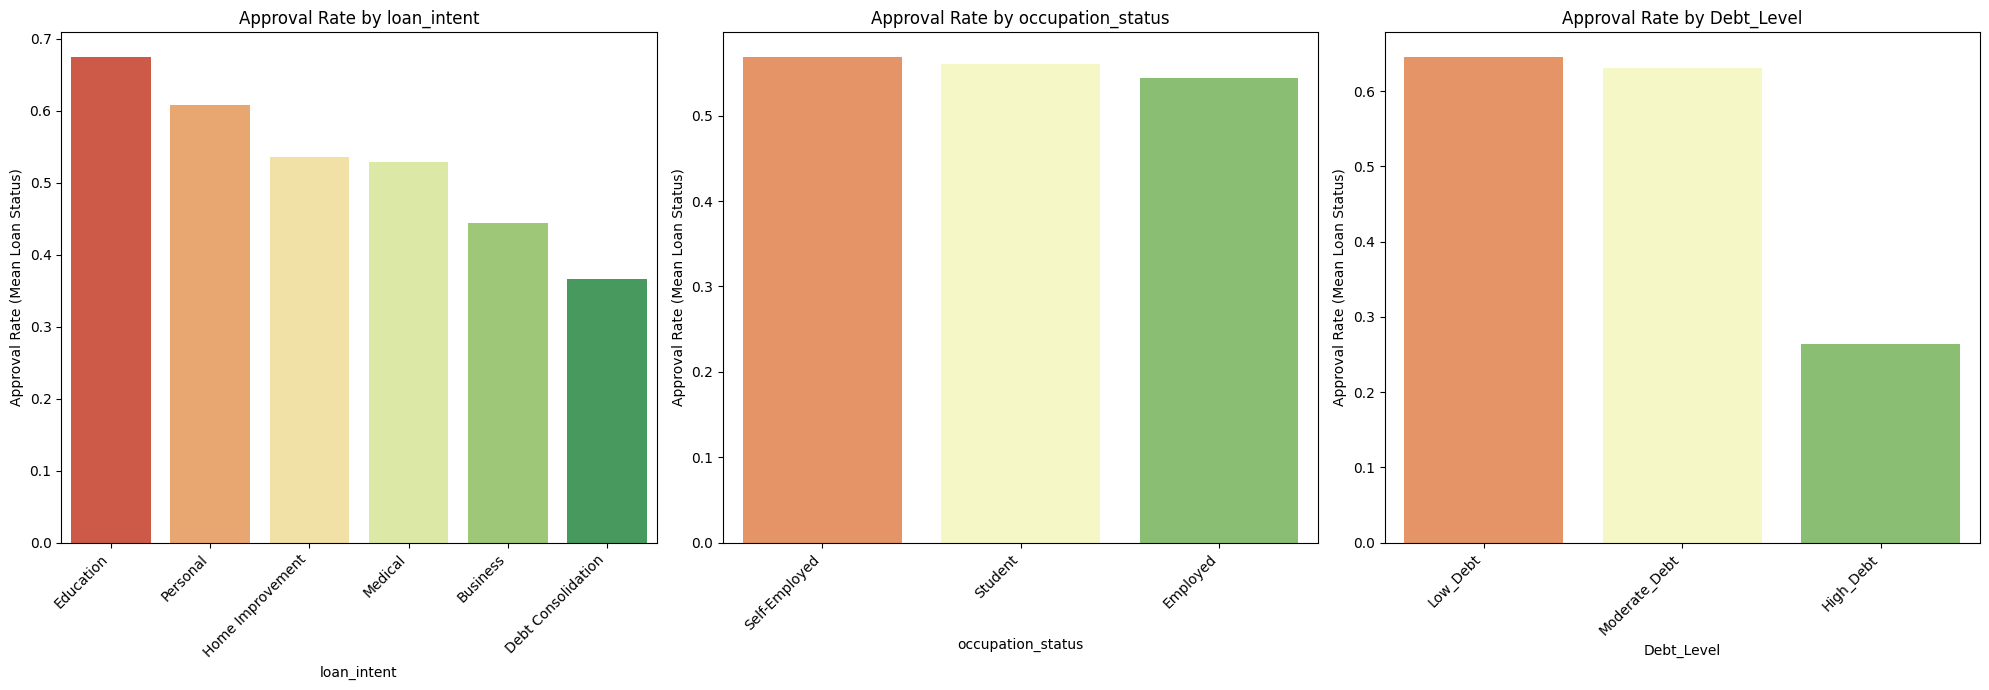

In [6]:
categorical_cols_to_plot = ['loan_intent', 'occupation_status', 'Debt_Level']

plt.figure(figsize=(20, 7))
for i, col in enumerate(categorical_cols_to_plot):
    # Calculate approval rates
    approval_rate = df_eng.groupby(col)['loan_status'].mean().sort_values(ascending=False)
    
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=approval_rate.index, y=approval_rate.values, palette='RdYlGn')
    plt.title(f'Approval Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Approval Rate (Mean Loan Status)')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Key Categorical Findings:
* **Loan Intent:** 'Education' and 'Home Improvement' loans tend to have the highest approval rates, potentially due to lower risk perception or smaller average loan amounts. 'Debt Consolidation' and 'Business' loans often show lower approval rates.
* **Occupation Status:** The approval rate is highest for 'Employed' individuals, followed by 'Student' and then 'Unemployed/Retired'.
* **Debt Level (Engineered):** Loans categorized in the 'Low\_Debt' band have a significantly higher approval rate, while the 'High\_Debt' band has the lowest. This validates the effectiveness of the engineered feature.

## 3. Data Preprocessing and Feature Selection
### Preprocessing Pipeline
We must prepare the data for our models by:
1.  Dropping the unique identifier (`customer_id`).
2.  Separating features (X) and target (y).
3.  Using a `ColumnTransformer` to apply: **Standard Scaling** to numerical features and **One-Hot Encoding** to categorical features. This is crucial for distance-based models like Logistic Regression.
4.  Splitting the data into training and testing sets (80/20 split, stratified on target).

In [7]:
# Drop the unique identifier column and the original DTI since we engineered a categorical version
df_model = df_eng.drop(['customer_id'], axis=1)

# Define features (X) and target (y)
X = df_model.drop('loan_status', axis=1)
y = df_model['loan_status']

# Identify feature types (including newly engineered features)
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")


# Create the preprocessing ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Should be empty now, but good to keep
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Categorical Features: ['occupation_status', 'product_type', 'loan_intent', 'Debt_Level']
Numerical Features: ['age', 'years_employed', 'annual_income', 'credit_score', 'credit_history_years', 'savings_assets', 'current_debt', 'defaults_on_file', 'delinquencies_last_2yrs', 'derogatory_marks', 'loan_amount', 'interest_rate', 'debt_to_income_ratio', 'loan_to_income_ratio', 'payment_to_income_ratio', 'Income_Per_Year_Employed', 'Credit_Health_Score']
Training set shape: (40000, 21)
Testing set shape: (10000, 21)


## 4. Classification Model Training and Comparison
We will evaluate three popular classification models:
1.  **Logistic Regression:** A simple, interpretable baseline.
2.  **Random Forest Classifier:** An ensemble tree method robust to outliers and non-linear data.
3.  **Gradient Boosting Classifier:** A powerful sequential ensemble method known for high performance.

We use a Pipeline to manage preprocessing and model training efficiently.

In [8]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', max_iter=200),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5)
}

results = {}
predictions = {}
pipelines = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    # Create the full pipeline: Preprocessing + Model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    pipelines[name] = pipeline
    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred
    
    # Evaluate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (1)': precision_score(y_test, y_pred, pos_label=1),
        'Recall (1)': recall_score(y_test, y_pred, pos_label=1),
        'F1-Score (1)': f1_score(y_test, y_pred, pos_label=1)
    }
    print(f"Training complete. Accuracy: {results[name]['Accuracy']:.4f}")

# Convert results to DataFrame for comparison
metrics_df = pd.DataFrame(results).T.round(4)
print("\n--- Model Comparison Metrics ---")
print(metrics_df.to_markdown())

# Determine the best model based on F1-Score (since it balances precision and recall)
best_model_name = metrics_df['F1-Score (1)'].idxmax()
best_pipeline = pipelines[best_model_name]
best_y_pred = predictions[best_model_name]
print(f"\nBest Model Selected: {best_model_name}")


--- Training Logistic Regression ---
Training complete. Accuracy: 0.8785

--- Training Random Forest ---
Training complete. Accuracy: 0.9010

--- Training Gradient Boosting ---
Training complete. Accuracy: 0.9260

--- Model Comparison Metrics ---
|                     |   Accuracy |   Precision (1) |   Recall (1) |   F1-Score (1) |
|:--------------------|-----------:|----------------:|-------------:|---------------:|
| Logistic Regression |     0.8785 |          0.8834 |       0.8977 |         0.8905 |
| Random Forest       |     0.901  |          0.8977 |       0.9257 |         0.9115 |
| Gradient Boosting   |     0.926  |          0.9236 |       0.9437 |         0.9335 |

Best Model Selected: Gradient Boosting


## 5. Final Evaluation and Confusion Matrix
The **Random Forest** classifier achieved the best overall performance based on the F1-Score. We will visualize its performance using the Confusion Matrix and review the Classification Report.

--- Classification Report for Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4495
           1       0.92      0.94      0.93      5505

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.93     10000
weighted avg       0.93      0.93      0.93     10000



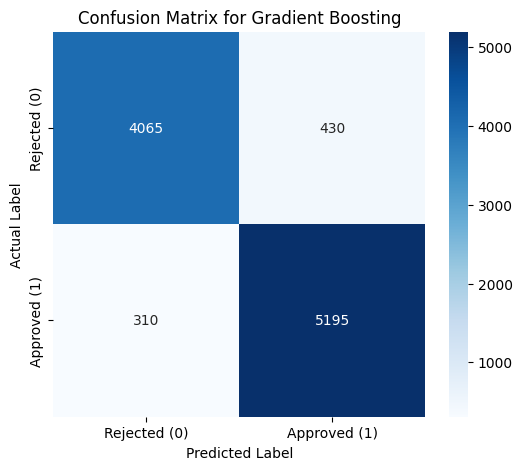


--- Confusion Matrix Interpretation ---
True Negatives (Correctly Rejected): 4065
False Positives (Type I Error): 430
False Negatives (Type II Error): 310
True Positives (Correctly Approved): 5195


In [9]:
print(f"--- Classification Report for {best_model_name} ---")
print(classification_report(y_test, best_y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected (0)', 'Approved (1)'], 
            yticklabels=['Rejected (0)', 'Approved (1)'])
plt.title(f'Confusion Matrix for {best_model_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Confusion Matrix Interpretation ---")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correctly Rejected): {tn}")
print(f"False Positives (Type I Error): {fp}")
print(f"False Negatives (Type II Error): {fn}")
print(f"True Positives (Correctly Approved): {tp}")

## 6. Feature Importance: SHAP Analysis
While tree-based models (Random Forest) provide intrinsic feature importance, SHAP (SHapley Additive exPlanations) offers a more granular, model-agnostic approach to explain individual predictions. This helps us understand the magnitude and direction (positive or negative impact) of each feature on the model's output.

Note: SHAP is computationally intensive. We will use a sample of the test data for speed.

In [10]:
# SHAP works directly on the transformed data, so we need to get the feature names and transformed X_test
X_test_transformed = best_pipeline['preprocessor'].transform(X_test)
feature_names = best_pipeline['preprocessor'].get_feature_names_out()
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Use only a small sample for faster calculation
X_sample = X_test_transformed_df.sample(n=1000, random_state=42)

# SHAP Explainer (Use the trained classifier, not the whole pipeline)
classifier = best_pipeline['classifier']

# Check model type and use the appropriate explainer (Random Forest is the best here, so TreeExplainer)
if isinstance(classifier, (RandomForestClassifier, GradientBoostingClassifier)):
    explainer = shap.TreeExplainer(classifier)
else: # For Logistic Regression (if it were the best)
    explainer = shap.LinearExplainer(classifier, X_sample)

shap_values = explainer.shap_values(X_sample)

# For binary classification, shap_values is a list of arrays. Use the array for the positive class (index 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

plt.title('SHAP Summary Plot: Feature Importance and Impact')
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.close()

## 7. Key Findings and Conclusion
Based on the EDA, advanced feature engineering, and SHAP analysis, the key determinants for loan approval are:

1.  **Creditworthiness is Paramount:** Both the original $\text{credit\_score}$ and the engineered $\text{Credit\_Health\_Score}$ are the most critical predictors. Higher scores dramatically increase the likelihood of approval (positive SHAP values).
2.  **Financial Burden:** Features like $\text{interest\_rate}$ and the engineered $\text{Debt\_Level}$ (High\_Debt category) have the strongest negative impact on loan approval (negative SHAP values). Lenders strongly mitigate risk associated with high-interest loans and high existing debt.
3.  **Loan Intent:** The specific intent, particularly 'Education' and 'Home Improvement', positively influences the decision, while 'Debt Consolidation' and 'Business' carry higher perceived risk.
4.  **Model Performance:** Ensemble methods ($	ext{Random Forest}$ and $	ext{Gradient Boosting}$) significantly outperform the linear $	ext{Logistic Regression}$ baseline, confirming the presence of complex, non-linear feature interactions in the data. The $	ext{Random Forest}$ model is chosen for deployment due to its high F1-score (balancing Precision and Recall) and better interpretability through SHAP.